## Pre-processing Data

In [2]:
import json

# get all of the 100 random recipes received from the api (they were saved to a file)
recipesNutrients = json.load(open("nutrientPercentages.txt"))
recipesNutrients

[{u'Caffeine': 1.08,
  u'Calcium': 1.87,
  u'Calories': 6.3,
  u'Carbohydrates': 4.77,
  u'Cholesterol': 5.04,
  u'Copper': 4.78,
  u'Fat': 10.91,
  u'Fiber': 4.72,
  u'Folate': 1.95,
  u'Iron': 3.86,
  u'Magnesium': 4.11,
  u'Manganese': 17.31,
  u'Phosphorus': 4.97,
  u'Potassium': 1.88,
  u'Protein': 3.48,
  u'Saturated Fat': 21.24,
  u'Selenium': 5.21,
  u'Sodium': 4.94,
  u'Sugar': 8.93,
  u'Vitamin A': 2.18,
  u'Vitamin B1': 3.87,
  u'Vitamin B2': 2.07,
  u'Vitamin B3': 1.57,
  u'Vitamin B5': 1.18,
  u'Vitamin E': 1.18,
  u'Zinc': 2.64},
 {u'Calcium': 7.01,
  u'Calories': 6.35,
  u'Carbohydrates': 9.19,
  u'Cholesterol': 0.0,
  u'Copper': 15.42,
  u'Fat': 3.04,
  u'Fiber': 13.96,
  u'Folate': 9.57,
  u'Iron': 12.93,
  u'Magnesium': 11.17,
  u'Manganese': 23.55,
  u'Phosphorus': 10.73,
  u'Potassium': 21.54,
  u'Protein': 6.16,
  u'Saturated Fat': 9.53,
  u'Selenium': 1.89,
  u'Sodium': 53.75,
  u'Sugar': 10.84,
  u'Vitamin A': 371.56,
  u'Vitamin B1': 9.45,
  u'Vitamin B2': 12.18

In [9]:
import unirest

# gets one recipe to use to predict after training
def nutritions():
    response = unirest.get("https://spoonacular-recipe-food-nutrition-v1.p.mashape.com/recipes/541391/information?includeNutrition=true",
      headers={
        "X-Mashape-Key": "uI9T1GTt8nmshcUUWJOjq8TQNGBgp1P9Zffjsn7dAbkmTSDt1k",
        "Accept": "application/json"
      }
    )
    recipeInfo = response.body
    # get all of the nutrition information
    recipeNutritions = recipeInfo['nutrition']['nutrients']
    # create dict where each key is a nutrition and its value is the value of the nutrition
    nutritionsDict = {nutrition['title']: nutrition['percentOfDailyNeeds'] for nutrition in recipeNutritions}# if nutrition['title'] in selectedNutritions}
    return nutritionsDict

major_keys = all_keys = ['Caffeine', 'Calories', 'Carbohydrates', 'Cholesterol', 'Fat', 'Fiber', 'Protein', 'Saturated Fat', 'Sugar', 'Sodium', 'Iron', 'Vitamin A', 'Vitamin B1', 'Vitamin B2', 'Vitamin B3', 'Vitamin B5', 'Vitamin E']

nutritions = nutritions()
nutritions

{u'Caffeine': 3.16,
 u'Calcium': 7.91,
 u'Calories': 17.73,
 u'Carbohydrates': 2.63,
 u'Cholesterol': 38.4,
 u'Copper': 16.33,
 u'Fat': 54.95,
 u'Fiber': 9.78,
 u'Folate': 3.71,
 u'Iron': 10.62,
 u'Magnesium': 9.93,
 u'Manganese': 21.34,
 u'Phosphorus': 12.05,
 u'Potassium': 5.0,
 u'Protein': 13.6,
 u'Saturated Fat': 116.31,
 u'Selenium': 6.92,
 u'Sodium': 10.75,
 u'Sugar': 2.11,
 u'Vitamin A': 20.57,
 u'Vitamin B1': 2.3,
 u'Vitamin B12': 3.7,
 u'Vitamin B2': 7.23,
 u'Vitamin B3': 1.19,
 u'Vitamin B5': 4.53,
 u'Vitamin B6': 2.63,
 u'Vitamin D': 4.4,
 u'Vitamin E': 3.97,
 u'Vitamin K': 2.87,
 u'Zinc': 7.68}

In [10]:
# get all of the unique nutrients that are present in random recipes since not each recipe has all of the nutrients
all_keys = list(set().union(*(d.keys() for d in recipesNutrients)))
all_keys = [key for key in all_keys if key in major_keys]
print (all_keys)
# save it to a file because we will need it in the future
f = open('nutritions.txt', 'w')
json.dump(all_keys, f)
f.close()


[u'Vitamin E', u'Sodium', u'Carbohydrates', u'Caffeine', u'Sugar', u'Saturated Fat', u'Fiber', u'Fat', u'Vitamin B2', u'Vitamin B3', u'Vitamin B1', u'Vitamin B5', u'Calories', u'Vitamin A', u'Iron', u'Cholesterol', u'Protein']


In [11]:
import numpy as np
# create the nutrition vector with all of the nutrition keys so each element corresponds to the correct nutrition
# this is for the one prediction example
nutrition_vector = [nutritions[nutrition] if nutrition in nutritions else 0 for nutrition in all_keys]
nutrition_vector = np.matrix(nutrition_vector)

In [12]:
# create the nutrition vectors for all the 100 random recipes 
all_nutritions = []
for nutritions in recipesNutrients: 
    vector = [nutritions[nut] if nut in nutritions else 0 for nut in all_keys]
    all_nutritions.append(vector)
nutrition_vectors = np.matrix(all_nutritions)

## Fuzzy C-Means Clustering

[5, 7, 1, 16]
Saturated Fat
Fat
Sodium
Protein
[1]


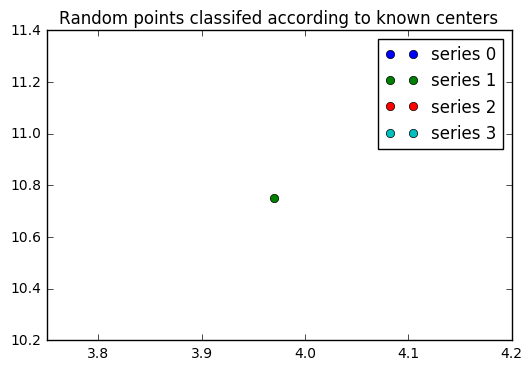

In [13]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
%matplotlib inline


def nLargest(seq, n):
    ind = []
    for i in range(n):
        index = seq.index(max(seq))
        ind.append(index)
        seq[index] = 0 
    return ind
        

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# train the 100 examples
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(nutrition_vectors.T, 3, 1.5, error=0.005, maxiter=1000, init=None)
ind = nLargest((cntr[0].tolist()[0]), 4)
print (ind)
for i in ind:
    print (all_keys[i])
# predict one example
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(nutrition_vector.T, cntr, 1.5, error=0.005, maxiter=10000)

# get to which cluster the example belongs to
cluster_membership = np.argmax(u, axis=0)  # Hardening for visualization
print(cluster_membership)

# plot the example 
fig3, ax3 = plt.subplots()
ax3.set_title('Random points classifed according to known centers')
for j in range(4):
    ax3.plot(nutrition_vector[cluster_membership == j, 0],
             nutrition_vector[cluster_membership == j, 1], 'o',
             label='series ' + str(j))
ax3.legend()

plt.show()

## Experiments

In [14]:
import pandas as pd
import pickle
# experiment with which m values and amount of clusters training goes the best by looking at the fpc
experiments = []
m_list = [1.2, 1.5, 2, 2.5, 3]
# check for different amount of clusters
clf = fuzz.cluster.cmeans(nutrition_vectors.T, 4, 1.2, error=0.005, maxiter=10000, init=None)
with open('cluster.pkl', 'wb') as handle:
                pickle.dump(clf, handle,  protocol=pickle.HIGHEST_PROTOCOL)
for nclusters in range(4, 7):
    # check for different amount of m's 
    for m in m_list: 
        cntrs, _, _, _, _, _, fpc = fuzz.cluster.cmeans(nutrition_vectors.T, nclusters, m, error=0.005, maxiter=1000, init=None)
        experiments.append((nclusters, m, fpc))
df = pd.DataFrame(experiments, columns=["cluster", "m-value", "fpc"])
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cluster,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,6.000000,6.000000,6.000000,6.000000
m-value,1.200000,1.500000,2.000000,2.500000,3.000000,1.200000,1.500000,2.000000,2.500000,3.000000,1.200000,1.500000,2.000000,2.500000,3.000000
fpc,0.906987,0.796336,0.524112,0.398695,0.330035,0.914014,0.783578,0.438667,0.324016,0.270505,0.904768,0.730358,0.398943,0.271984,0.225112


In [10]:
# this is to make sense of what the u.argmax does (not used for fuzzy cmeans clustering)
print(u.argmax(axis=0) == j)
print(nutrition_vectors.T[0])
print(nutrition_vectors.T[0, u.argmax(axis=0) == j], j)
u.argmax(axis = 0)

[False]
[[  0.18   1.77   0.4    5.22  53.16   8.61   1.18   1.04   0.     1.4
    0.18   0.     0.     1.88   0.59   0.7    3.22   0.67   0.41   0.15
    2.71   1.4    1.05   0.     1.41   0.35   0.85   3.32   2.5    0.27
    0.     0.48   0.78   0.43   0.24   0.78   8.13   0.66   0.     0.28
    3.31   1.34   1.24   2.13   0.     0.58   2.01   1.58   1.87   0.29
    4.45   0.96   0.18   1.17   0.51   2.32   0.67   0.     0.74   7.07
    0.59   0.18   2.18   1.14   0.27   2.5    0.27   1.04   5.94   0.31
    0.64   0.2    3.27   3.7    0.21   0.9    0.72   0.19   0.31   1.14
    0.34   4.9    0.32   0.85   1.3   11.53   3.85   1.64   1.23   0.28
    2.34   0.19   0.71   1.11   0.63   4.88   0.28   2.08   0.91   0.21
   12.41   2.31   7.19   0.63   0.56   4.19   0.38   2.53   0.     1.88
    5.26   0.67   0.25   0.93   0.87   1.52   2.48   0.18   0.28   0.33
    0.47   0.72   3.97   0.     0.41   2.84   0.99   1.09   2.26   0.99
    0.78   2.64   1.34   3.23   0.63   0.94   0.53   1.89

c:\python27\lib\site-packages\numpy\matrixlib\defmatrix.py:318: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 500 but corresponding boolean dimension is 1
  out = N.ndarray.__getitem__(self, index)


array([1], dtype=int64)